In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time
from scipy import signal
import os
import pandas as pd

In [14]:
class FileClass:
    def __init__(self, sig, inst):
        self.signal = sig
        self.instrument = inst
        self.rmsAverage = 0
        self.spectralCentroidAverage = 0
        self.spectralBandwidthAverage = 0
        
    def addAverages(rms, sc, sb):
        self.rmsAverage = rms
        self.spectralCentroidAverage = sc
        self.spectralBandwidthAverage = sb
        
class InstrumentFilters:
    def __init__(self):
        self.firTaps = 20
        self.fc = 0.1

In [70]:
def graph_spectrogram(s,titleBeginning):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(titleBeginning + " Spectrogram")
    plt.show()
    
def graph_calculation_vs_librosa(calculated, fromLibrosa, titleBeginning):
    t = np.linspace(0, len(calculated), len(calculated))
    print(t)
    plt.figure(figsize=(20, 3))
    plt.plot(t, calculated, 'b', t, fromLibrosa, 'r--')
    plt.legend(('calculated', 'librosa'), loc='best')
    plt.title(titleBeginning + " Calculated Vs. Librosa")
    plt.grid(True)
    plt.show()

In [73]:
# Create list of file classes, which store file name, instrument, rms, spectral centroid, and spectral bandwidth
fileClasses = {}
instrumentTypes = []

dataFrame = pd.read_csv('./files/database/meta.csv')
# store file names and instruments in arrays we are assuming that row 0 is files and row 1 is instruments)
columnNames = dataFrame.columns.values
fileNames = dataFrame[columnNames[0]]
instrument = dataFrame[columnNames[1]]


# iterate through columns
for i in range(0, fileNames.size):
    y, sr = librosa.load('./files/database/' + fileNames[i], sr=48000, mono=True)
    newClass = FileClass(y, instrument[i])
    fileClasses[fileNames[i]] = newClass
    
    #Find all types of instruments
    foundInstrument = False
    for inst in instrumentTypes:
        if inst == instrument[i]:
            foundInstrument = True
            break
    
    if foundInstrument == False:
        instrumentTypes.append(instrument[i])
        
print(instrumentTypes)

['cello', 'guitar', 'clarinet', 'flute', 'harmonica']


In [56]:
# These lists will hold the average values of our calculated values and librosa values for RMS and spectral centroid 
# so we can compare them after we go through each file
calculatedRmsArray = []
librosaRmsArray = []
calculatedSpectralCentroidArray = []
librosaSpectralCentroidArray = []
for file in fileClasses:
    if (file.endswith('.' + 'wav')):
        # Load file and perform FFT
        y = fileClasses[file].signal
        S = np.abs(scipy.fft.fft(y))
        magnitude = np.abs(S[0:math.floor(len(S)/2)+1])
        
        #TODO: ADD EQUATIONS FOR RMS AND SPECTRAL CENTROID
        rmsAverage = math.sqrt(np.sum(pow(S, 2)) / pow(S.size, 2))
        calculatedRmsArray.append(rmsAverage)
                   
        rmsLibrosaAverage = librosa.feature.rms(S=magnitude, frame_length=(magnitude.size * 2 - 1))[0]
        librosaRmsArray.append(rmsLibrosaAverage)
        
        freqs = np.linspace(0, sr/2, magnitude.size)
        scAverage = (np.sum(magnitude * freqs)) / np.sum(magnitude)
        calculatedSpectralCentroidArray.append(scAverage)
        
        scLibrosaAverage = librosa.feature.spectral_centroid(y=y, sr=48000, n_fft=y.size, hop_length=(y.size + 1))[0][0]
        librosaSpectralCentroidArray.append(scLibrosaAverage)

60
60
[ 0.          1.01694915  2.03389831  3.05084746  4.06779661  5.08474576
  6.10169492  7.11864407  8.13559322  9.15254237 10.16949153 11.18644068
 12.20338983 13.22033898 14.23728814 15.25423729 16.27118644 17.28813559
 18.30508475 19.3220339  20.33898305 21.3559322  22.37288136 23.38983051
 24.40677966 25.42372881 26.44067797 27.45762712 28.47457627 29.49152542
 30.50847458 31.52542373 32.54237288 33.55932203 34.57627119 35.59322034
 36.61016949 37.62711864 38.6440678  39.66101695 40.6779661  41.69491525
 42.71186441 43.72881356 44.74576271 45.76271186 46.77966102 47.79661017
 48.81355932 49.83050847 50.84745763 51.86440678 52.88135593 53.89830508
 54.91525424 55.93220339 56.94915254 57.96610169 58.98305085 60.        ]


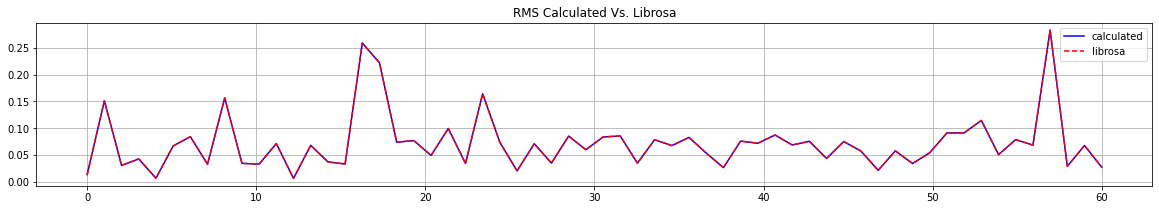

[ 0.          1.01694915  2.03389831  3.05084746  4.06779661  5.08474576
  6.10169492  7.11864407  8.13559322  9.15254237 10.16949153 11.18644068
 12.20338983 13.22033898 14.23728814 15.25423729 16.27118644 17.28813559
 18.30508475 19.3220339  20.33898305 21.3559322  22.37288136 23.38983051
 24.40677966 25.42372881 26.44067797 27.45762712 28.47457627 29.49152542
 30.50847458 31.52542373 32.54237288 33.55932203 34.57627119 35.59322034
 36.61016949 37.62711864 38.6440678  39.66101695 40.6779661  41.69491525
 42.71186441 43.72881356 44.74576271 45.76271186 46.77966102 47.79661017
 48.81355932 49.83050847 50.84745763 51.86440678 52.88135593 53.89830508
 54.91525424 55.93220339 56.94915254 57.96610169 58.98305085 60.        ]


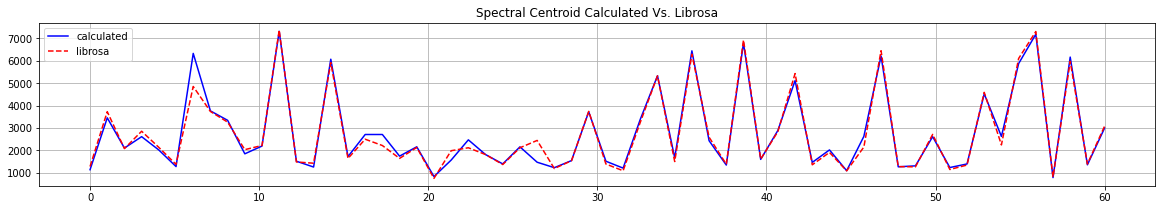

In [72]:
print(len(librosaRmsArray))
print(len(calculatedRmsArray))
graph_calculation_vs_librosa(calculatedRmsArray, librosaRmsArray, "RMS Average")
graph_calculation_vs_librosa(calculatedSpectralCentroidArray, librosaSpectralCentroidArray, "Spectral Centroid Average")

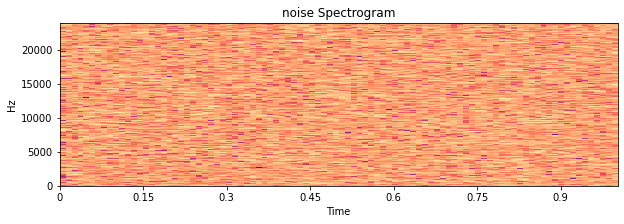

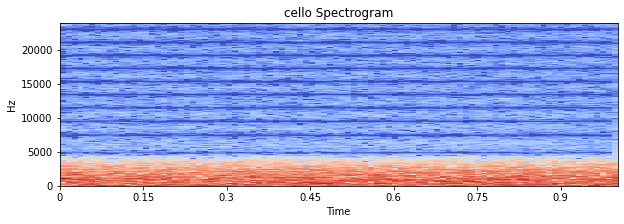

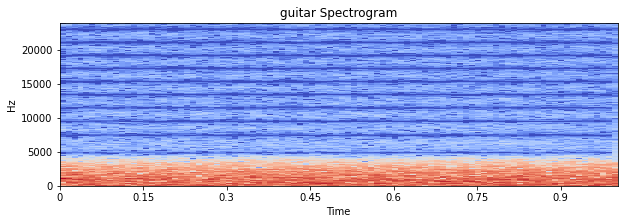

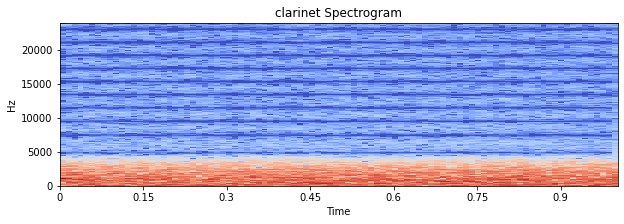

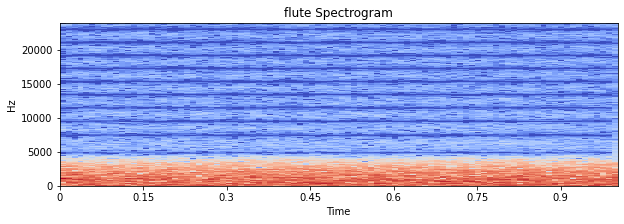

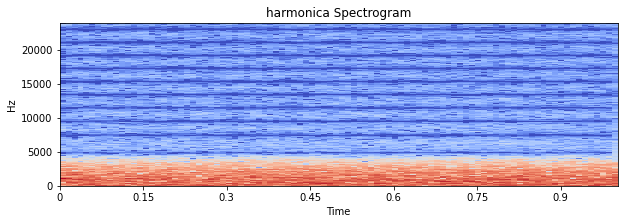

In [38]:
instrumentFilters = {}

# Create filters for each instrument
for instrument in instrumentTypes:
    instrumentFilters[instrument] = InstrumentFilters()

# Apply filters to a 1 second noise array to display effects
noise = np.random.normal(0,1,48000)
graph_spectrogram(noise, "noise")

for instrument in instrumentFilters:
    filters = instrumentFilters[instrument]
    numtaps = filters.firTaps
    fc = filters.fc
    h = signal.firwin(25, 0.05, pass_zero='lowpass')
    filtered = signal.lfilter(h, 1, noise)
    graph_spectrogram(filtered, instrument)

In [41]:
# Apply filters to all audio files
for file in fileClasses:
    y = fileClasses[file].signal
    instrument = fileClasses[file].instrument
    filters = instrumentFilters[instrument]
    numtaps = filters.firTaps
    fc = filters.fc
    h = signal.firwin(numtaps, fc, pass_zero=True)
    h_padded = np.pad(h,[0,y.size-h.size])
    X = scipy.fft.fft(y)
    H = scipy.fft.fft(h_padded)
    Y = X*H
    # signal with FIR filter applied
    y = np.real(scipy.fft.ifft(Y))

KeyboardInterrupt: 